In [1]:
import json, os
import cv2
import torch
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.data_loader import KeypointsDataset, NormalizeCentered2D, ToTensor, BODY_PARTS
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import random
import torch
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt

In [3]:
ADIPOSE_FIN = 'ADIPOSE_FIN'
ANAL_FIN = 'ANAL_FIN'
DORSAL_FIN = 'DORSAL_FIN'
EYE = 'EYE',
PECTORAL_FIN = 'PECTORAL_FIN'
PELVIC_FIN = 'PELVIC_FIN'
TAIL_NOTCH = 'TAIL_NOTCH'
UPPER_LIP ='UPPER_LIP'

In [4]:

class NormalizedStabilityTransform(object):
    """
        Transforms world keypoints into a more stable coordinate system - this will lead to better
        training / convergene
    """
    
    def __call__(self, sample):
        modified_kps, label, stereo_pair_id, cm = \
            sample['modified_kps'], sample['label'], sample['stereo_pair_id'], sample['cm']
        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
        stabilized_coordinates = {}
        for bp in BODY_PARTS:
            wkp = modified_wkps[bp]
            stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
            stabilized_coordinates[bp] = stabilized_kp_info
            
        normalized_label = label * 1e-4 if label else None
        
        transformed_sample = {
            'kp_input': stabilized_coordinates,
            'label': normalized_label,
            'stereo_pair_id': stereo_pair_id,
            'single_point_inference': sample.get('single_point_inference')
        }
        
        return transformed_sample

In [10]:
from sqlalchemy import create_engine


In [11]:
prod_sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format("aquabyte_ro", 
            "bJndX#uJ7VNVDJQW8g",
            "aquabyte-research-db.cfwlu7jbdcqj.eu-west-1.rds.amazonaws.com", 
            "5432",
            "aquabyte_prod"))
prod_db_connection = prod_sql_engine.connect()


In [14]:
# load gtsf data

#rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints -> 'leftCrop' is not null
    and b.keypoints -> 'rightCrop' is not null
    and b.is_qa = false
    order by b.captured_at
"""

results = prod_db_connection.execute(query)
df_gtsf = pd.DataFrame(results.fetchall())
df_gtsf.columns = results.keys()



In [15]:
df_gtsf.head()

,left_url,fish_id,weight,data,stereo_parameters_url,ts_created,ts_updated,data_collection_type_id,id,fish_detection_id,...,site_id,pen_id,left_image_url,right_image_url,left_crop_metadata,right_crop_metadata,camera_metadata,captured_at,is_obscured_floy_tag,is_floy_tag_not_present
0,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010002,2427,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:21.884070+00:00,2019-08-09 05:30:21.884070+00:00,None,509178,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2339, 'height': 702, 'x_coord': 634,...","{'width': 2319, 'height': 709, 'x_coord': 172,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:07:45.908000+00:00,None,None
1,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010003,2300,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:19.685998+00:00,2019-08-09 05:30:19.685998+00:00,None,509176,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2340, 'height': 714, 'x_coord': 642,...","{'width': 2278, 'height': 684, 'x_coord': 213,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:10:40.248000+00:00,None,None
2,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010004,1903,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:22.664575+00:00,2019-08-09 05:30:22.664575+00:00,None,509179,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2216, 'height': 637, 'x_coord': 684,...","{'width': 2238, 'height': 654, 'x_coord': 205,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:13:18.999000+00:00,None,None
3,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010006,1835,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:12.022678+00:00,2019-08-09 05:30:12.022678+00:00,None,509159,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2255, 'height': 612, 'x_coord': 702,...","{'width': 2344, 'height': 637, 'x_coord': 115,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:18:21.621000+00:00,None,None
4,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,190301010007,1924,"{'species': 'salmon', 'location': 'Generic', '...",https://aquabyte-stereo-parameters.s3-eu-west-...,2019-08-09 05:30:06.538102+00:00,2019-08-09 05:30:06.538102+00:00,None,509151,None,...,35,48,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,https://s3-eu-west-1.amazonaws.com/aquabyte-cr...,"{'width': 2215, 'height': 630, 'x_coord': 685,...","{'width': 2262, 'height': 654, 'x_coord': 205,...","{'baseline': 0.12693501988129197, 'focalLength...",2019-03-01 09:22:01.397000+00:00,None,None


In [16]:
df_gtsf['data_collection_type_id'].unique()

array([None], dtype=object)

# load pre_trained model

In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x

biomass_network = torch.load('/root/data/alok/biomass_estimation/results/neural_network/2019-11-08T00:13:09/nn_epoch_798.pb')

In [18]:
# amg = AccuracyMetricsGenerator()
# amg.generate_accuracy_metrics(y_pred, df_gtsf['weight'], None)

In [19]:
df

NameError: name 'df' is not defined

In [20]:
get_MPE(y_pred, df_gtsf['weight'])

NameError: name 'get_MPE' is not defined

In [21]:
get_MAPE(y_pred, df_gtsf['weight'])


NameError: name 'get_MAPE' is not defined

In [22]:
def get_MPE(y_predict, y_train):
    # calculate mean percentage error
    return np.mean((y_train - y_predict) / y_train)

def get_MAPE(y_predict, y_train):
    # calcuate mean absolute percentage error
    return np.mean(np.absolute((y_train - y_predict) / y_train))

# Unit test

In [23]:
row = df_gtsf.iloc[13752]
input_sample = {
    'keypoints': row.keypoints,
    'cm': row.camera_metadata,
    'stereo_pair_id': row.id,
    'single_point_inference': True
}
nomralized_centered_2D_kps = \
        normalize_centered_2D_transform.__call__(input_sample)

normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
normalized_3D_kps = normalized_stability_kps['kp_input']

NameError: name 'normalize_centered_2D_transform' is not defined

In [24]:
def get_cos(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [25]:
normalized_3D_kps

NameError: name 'normalized_3D_kps' is not defined

## Orientation

In [26]:

def get_orientation(normalized_3D_kps):
    # degree between tail to lip vector and 
    tail_lip = np.array(normalized_3D_kps[TAIL_NOTCH]) - np.array(normalized_3D_kps[UPPER_LIP])
    x_hat = np.array([1, 0, 0])
    tail_lip_xy_proj = tail_lip * np.array([1, 1, 0])
    cos_phi = get_cos(x_hat, tail_lip_xy_proj)
    return np.degrees(np.arccos(cos_phi))


In [27]:
get_orientation(normalized_3D_kps)


NameError: name 'normalized_3D_kps' is not defined

## Curvature

In [28]:
def get_curvature(normalized_3D_kps):
    dorsal_lip = np.array(normalized_3D_kps[DORSAL_FIN]) - np.array(normalized_3D_kps[UPPER_LIP])
    dorsal_tail = np.array(normalized_3D_kps[DORSAL_FIN]) - np.array(normalized_3D_kps[TAIL_NOTCH])

    dorsal_lip_xy_proj = dorsal_lip * np.array([1, 1, 0])
    dorsal_tail_xy_proj = dorsal_tail * np.array([1, 1, 0])

    cos_alpha = get_cos(dorsal_lip_xy_proj, dorsal_tail_xy_proj)
    return np.degrees(np.arccos(cos_alpha))



# lean

In [29]:
def get_lean(normalized_3d_kps):
    tail_lip = np.array(normalized_3D_kps[TAIL_NOTCH]) - np.array(normalized_3D_kps[UPPER_LIP])
    tail_lip_xz_proj = tail_lip * np.array([1, 0, 1])
    x_hat = np.array([1, 0, 0])
    cos_beta = get_cos(tail_lip_xz_proj, x_hat )
    return np.degrees(np.arccos(cos_beta))

In [30]:
def get_size(weight):
    if weight < 2000:
        return 'small'
    if weight < 6000:
        return 'medium'
    else:
        return 'large'

In [31]:
normalize_centered_2D_transform = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()
to_tensor_transform = ToTensor()


df = pd.DataFrame(columns=["fish_id"
                           ,"weight"
                           ,"input_sample"
                           ,"orientation"
                           ,"curvature"
                           ,"lean"
                           ,"predicted_weight"
                           ,"size"
                          ])
y_pred = []

for idx, row in df_gtsf.iterrows():
    input_sample = {
        'keypoints': row.keypoints,
        'cm': row.camera_metadata,
        'stereo_pair_id': row.id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps) 
    normalized_3D_kps = normalized_stability_kps['kp_input']
    weight_prediction = biomass_network(tensorized_kps['kp_input']).item() * 1e4
    ornt = get_orientation(normalized_3D_kps)
    curv = get_curvature(normalized_3D_kps)
    lean = get_lean(normalized_3D_kps)
    df = df.append({'fish_id': row['fish_id']
                  ,'input_sample':input_sample
                  ,'weight': row['weight']
                  ,"orientation":ornt
                  ,"curvature":curv
                  ,"lean":lean
                  ,"predicted_weight":weight_prediction}, ignore_index=True)   

    
df['weight'] = df['weight'].astype(int)
df['error'] = df['weight'] - df['predicted_weight']
df['size'] = df['weight'].apply(get_size)       

In [32]:
df.shape

(15965, 9)

In [33]:
df.head(10)

,fish_id,weight,input_sample,orientation,curvature,lean,predicted_weight,size,error
0,190301010002,2427,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",177.963460,154.705176,179.472124,2340.981066,medium,86.018934
1,190301010003,2300,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",176.228311,159.448862,179.710985,2165.283114,medium,134.716886
2,190301010004,1903,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",179.111454,156.619750,179.562471,1858.538687,small,44.461313
3,190301010006,1835,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",179.010362,154.457552,179.588318,1927.961111,small,-92.961111
4,190301010007,1924,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",178.818454,156.835940,179.667448,1893.900633,small,30.099367
5,190301010008,1854,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",178.187207,159.819930,179.616095,1840.741336,small,13.258664
6,190301010009,2266,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",178.912261,157.943223,179.653100,2157.281935,medium,108.718065
7,190301010010,1848,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",179.913686,153.370700,179.501356,1777.640581,small,70.359419
8,190301010011,2007,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",178.471055,156.366507,179.464446,1936.170757,medium,70.829243
9,190301010012,2138,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",179.779352,152.589817,179.674073,2182.433754,medium,-44.433754


In [34]:
sum(df['size'] == 'small') / df.shape[0]

0.03877231443783276

In [35]:
sum(df['size'] == 'medium') / df.shape[0]

0.6024428437206389

In [36]:
sum(df['size'] == 'large') / df.shape[0]

0.35878484184152837

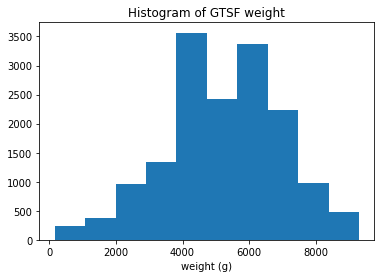

In [37]:
_ = plt.hist(df['weight'], bins=10)  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram of GTSF weight")
plt.xlabel('weight (g)')
plt.show()

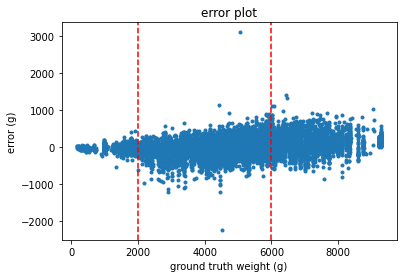

In [41]:
plt.title('error plot')

plt.axvline(x=2000, color='r', linestyle='--')
plt.axvline(x=6000, color='r', linestyle='--')
plt.scatter('weight', 'error', data = df, marker='.')
plt.xlabel('ground truth weight (g)')
plt.ylabel('error (g)')
plt.show()

In [46]:
df[df.error == df.error.max()]

,fish_id,weight,input_sample,orientation,curvature,lean,predicted_weight,size,error
903,190513010075,5057,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",174.699915,168.261551,179.631724,1956.571937,medium,3100.428063


In [47]:
df[df.error == df.error.min()]

,fish_id,weight,input_sample,orientation,curvature,lean,predicted_weight,size,error
14904,190808-d20dc94e-fc76-4ffb-a4f5-f296d9ac368d,4525,"{'keypoints': {'version': 2, 'leftCrop': [{'xC...",178.670985,149.417865,179.984124,6765.114069,medium,-2240.114069


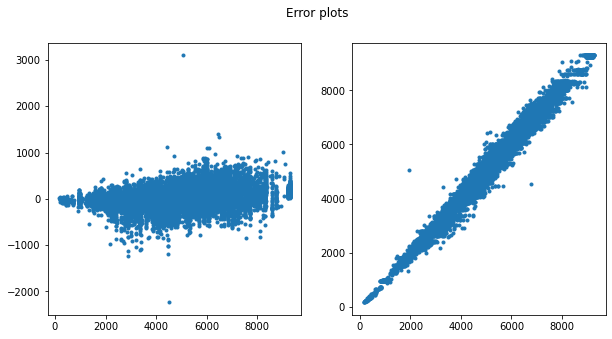

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
fig.suptitle('Error plots')
ax1.plot('weight', 'error', 
         data=df, linestyle='none', marker='.')
ax2.plot('predicted_weight', 'weight', 
         data=df, linestyle='none', marker='.')
plt.show()

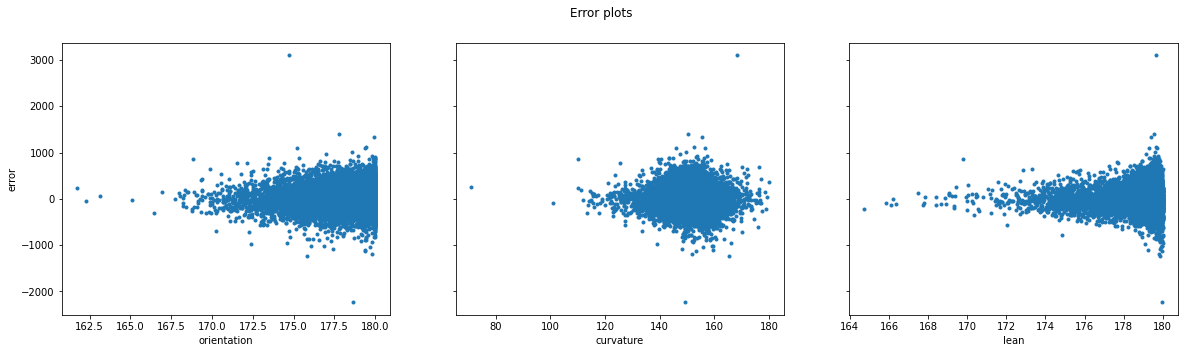

In [40]:
fig, axes = plt.subplots(1, 3,figsize=(20, 5), sharey=True)
fig.suptitle('Error plots')

axes[0].plot('orientation', 'error', 
         data=df, linestyle='none', marker='.')
axes[0].set(xlabel='orientation', ylabel='error')

axes[1].plot('curvature', 'error', 
         data=df, linestyle='none', marker='.')
axes[1].set(xlabel='curvature')

axes[2].plot('lean', 'error', 
         data=df, linestyle='none', marker='.')
axes[2].set(xlabel='lean')

plt.show()

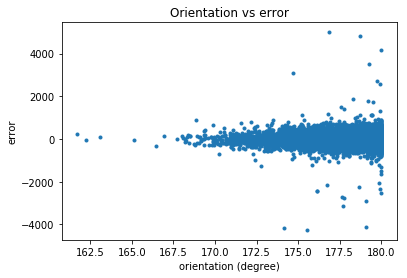

In [683]:
plt.plot('orientation', 'error', 
         data=df.drop([np.argmin(df['orientation'])], axis = 0), linestyle='none', marker='.')
plt.title('Orientation vs error')
plt.xlabel('orientation (degree)')
plt.ylabel('error')
plt.show()

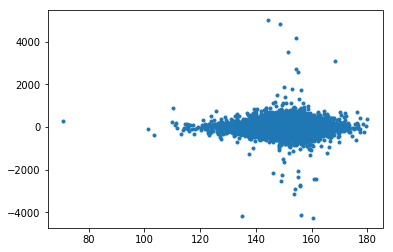

In [484]:
plt.plot('curvature', 'error', 
         data=df, linestyle='none', marker='.')
plt.show()

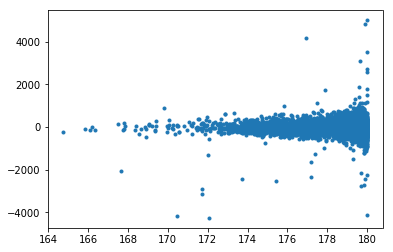

In [688]:
plt.plot('lean', 'error', 
         data=df, linestyle='none', marker='.')
plt.show()

In [319]:
df['lean'].describe()

count    16080.000000
mean       179.083154
std          1.920777
min          1.722304
25%        179.115195
50%        179.536573
75%        179.717663
max        180.000000
Name: lean, dtype: float64

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


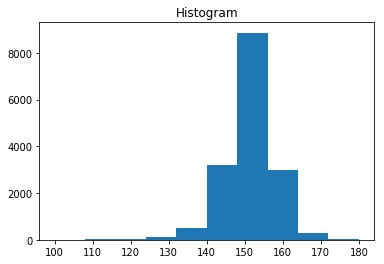

In [321]:
_ = plt.hist(df['curvature'], bins=10, range = (100, 180))  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram")

plt.show()

# regression model

In [726]:
df.dropna(inplace = True) # keypoints nan leads to orientation nan
df = df.drop(df[df['orientation'] < 90].index)
X = df[['size', 'orientation']]
X['size'] = X['size'].astype('category')
X = pd.get_dummies(X, columns=['size'], prefix = ['size'])


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [727]:
X.head(5)

,orientation,size_large,size_medium,size_small
0,177.963460,0,1,0
1,176.228311,0,1,0
2,179.111454,0,0,1
3,179.010362,0,0,1
4,178.818454,0,0,1


In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    df.error,
                                                    test_size=0.2, 
                                                    random_state=0)

In [495]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [496]:
print(regressor.score(X_test, y_test))

0.04321701963431146


In [497]:
regressor.coef_ 

array([ -2.13094026,  78.63581789, -41.2679192 , -37.36789869])

overpredict when more alined with the frame

underpredict for large fish

In [509]:
get_MPE(df[df['size'] == 'small']['predicted_weight'],
        df[df['size'] == 'small']['weight'])

-0.03220385360134271

In [681]:
get_MPE(df[df['size'] == 'medium']['predicted_weight'],
        df[df['size'] == 'medium']['weight'])

-0.009160165813080257

In [510]:
get_MPE(df[df['size'] == 'large']['predicted_weight'],
        df[df['size'] == 'large']['weight'])

0.012996370677223059

In [511]:
df[df['size'] == 'large'].shape[0]

5763

In [512]:
df[df['size'] == 'medium'].shape[0]

9678

In [569]:
df[df['size'] == 'small'].shape[0]

622

In [571]:
ind = np.argmin(df[df['size'] == 'small']['error'])
f_id = df[df['size'] == 'small'].iloc[ind]['fish_id']

df.loc[df['fish_id'] == f_id].shape

(58, 9)

In [572]:
# df_gtsf.loc[df_gtsf['fish_id'] == f_id]['id']

In [600]:
# df_gtsf.loc[df_gtsf['id'] == 606388]['keypoints'].values

In [653]:
val, cnt = np.unique(df['fish_id'], return_counts=True)


In [654]:
f_ids = val[cnt > 20]

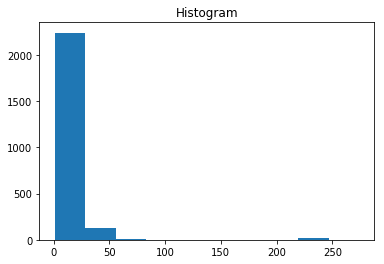

In [655]:
_ = plt.hist(cnt, bins=10)  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=300)
plt.title("Histogram")

plt.show()

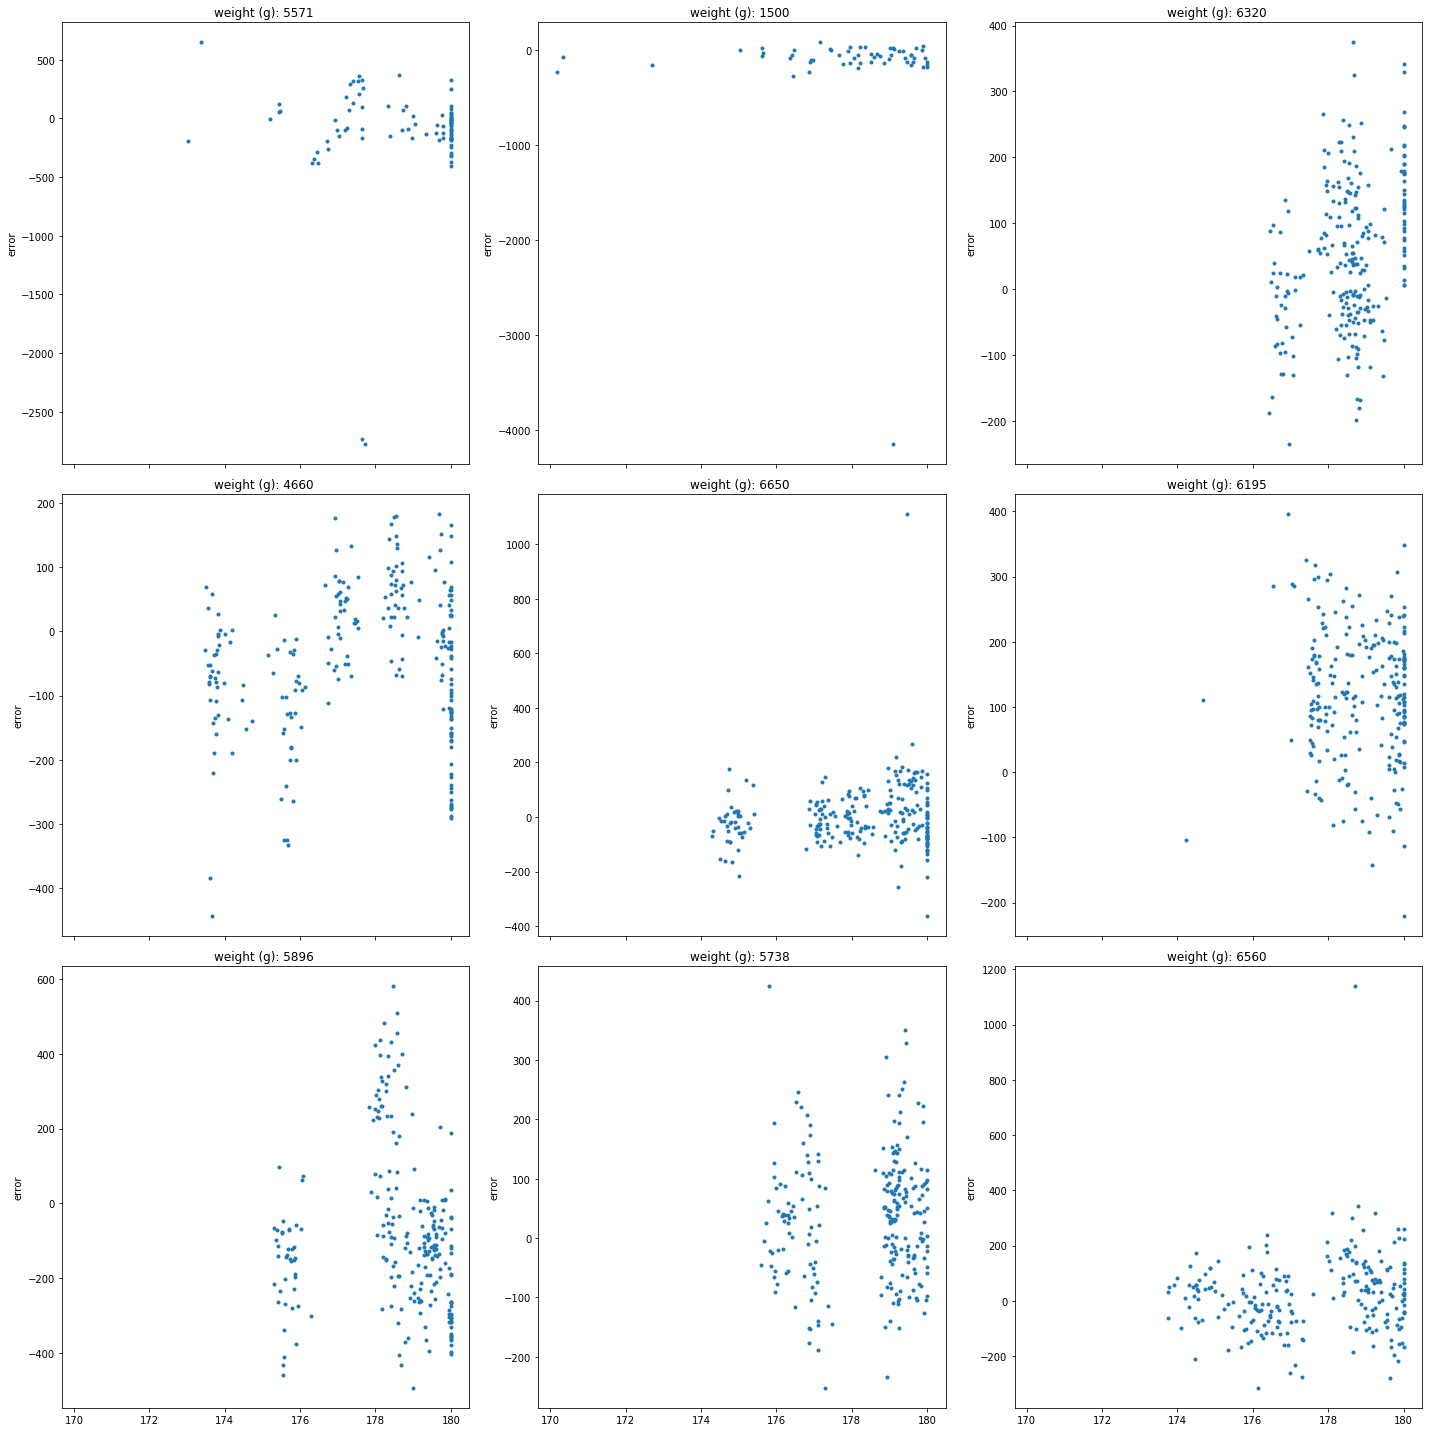

In [744]:
figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharex=True)

for i in range(3):
    for j in range(3):
        # axes.ylim(-500, 500)
        f_id = f_ids[i * 3 + j]
        temp = df.loc[df['fish_id'] == f_id]
        axes[i, j].plot('orientation', 'error',
                        data=temp, linestyle='none', marker='.')
        axes[i, j].set_title('weight (g): {} '.format(temp['weight'].iloc[0]))

        axes[i, j].set(ylabel='error')

#plt.xlabel('orientation')        
figure.tight_layout()


In [658]:
f_ids

array(['190607010041_bolaks-mjanes',
       '190620-4e4e0640-d4eb-405d-8fcf-57fda11d7660',
       '190710-0d45381d-1ed5-474c-aaea-454aaacb3e98',
       '190710-2c750417-6b12-4819-b93f-2790f4bdb7d4',
       '190710-2dcdda0c-502d-4bfc-9ce4-6ebb343e3f52',
       '190710-4b1d997a-3a6a-43c7-be18-f26ec00fc92d',
       '190710-5ff011b3-fecc-4bb1-9c97-4f66b06426e1',
       '190710-6ce48c82-6acc-4732-8622-7288c62a955f',
       '190710-8bfd8c70-4398-474e-8873-ee91bbbe0f39',
       '190710-b195a1ed-5117-4c90-ab8d-b411e3de5a57',
       '190710-b63cbe32-afbf-47c7-b881-cc0945691569',
       '190710-b8bd6e46-8eb3-4ba8-a47f-3f77184bc143',
       '190710-c7371830-1799-49ee-81bb-76d9b882fcee',
       '190710-ce6f49e0-eb12-4655-985b-0fdd82ab519a',
       '190710-e41ce0c1-62c8-48c3-af33-de2c6ec5e439',
       '190710-eadbdd6b-6076-49f5-bef4-ded2806de31d',
       '190710-f00b28d9-6921-4ce7-9193-a567a483e4d0',
       '190710-f1a56afc-326d-4c6c-8e2e-19e111d370f1',
       '190710-f2035bc1-8ea7-480a-8f40-622afc

weight of the fish 9290


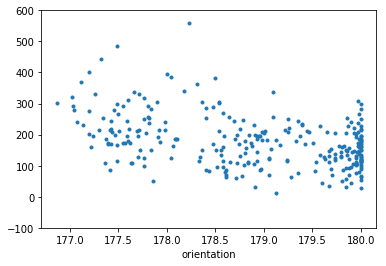

In [737]:
# get rows for the fish that have most records
f_id = val[np.argmax(cnt)]
#f_id = '190710-ce6f49e0-eb12-4655-985b-0fdd82ab519a'
#f_id = '190717-d2573589-6b5b-4f19-a0b9-4714432b5209'
#f_id = '190725-56a4b6d5-edfb-4fc2-9f81-cb152901da40'

temp = df.loc[df['fish_id'] == f_id]
print('weight of the fish', temp['weight'].iloc[0])
plt.ylim(-100, 600) 
plt.plot('orientation', 'error', 
         data=temp, linestyle='none', marker='.')
plt.xlabel("orientation")
plt.ylabel("")
plt.show()


In [661]:
coff = []
for f_id in f_ids:
    temp = df.loc[(df['fish_id'] == f_id) & (np.absolute(df['error']) < 800)]
    X = temp[['orientation']] 
    X_train, X_test, y_train, y_test = train_test_split(X, temp.error, test_size=0.2, random_state=0)
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    coff.append(regressor.coef_)
np.mean(coff)

-2.355771952857224